In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

# 设置硬件设备，如果有GPU则使用，没有则使用cpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


device(type='cuda')

## 第一步：前期准备
导入 PyTorch、torchvision、matplotlib 等包

设置设备：GPU 如果有就用，没的话用 CPU

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```

## 第二步：加载数据
使用 torchvision.datasets.MNIST() 下载并加载数据

DataLoader 用来分批次加载数据（batch size = 32）

```python
train_ds = torchvision.datasets.MNIST('data', train=True, transform=..., download=True)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
```

## 第三步：构建神经网络（CNN）
用 nn.Sequential 一次性定义网络结构（卷积、池化、全连接等）

```python
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    ...
).to(device)
```

## 第四步：训练模型

清空梯度： optimizer.zero_grad()
计算损失反向传播： loss.backward()
更新权重： optimizer.step()

<table><tr><td>torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)</td></tr></table>

- root: 数据地址
- train: True - training set; False - test set
- download: True - download from oneline
- transform: 选择数据转化函数
- target_transform: 接受目标并对其进行转换的函数/转换。

In [2]:
# 下载并加载MNIST数据集
train_ds = torchvision.datasets.MNIST('data', 
                                        train=True, 
                                        transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                        download=True)

test_ds  = torchvision.datasets.MNIST('data', 
                                      train=False, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

<table><tr><td>torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=None, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None, generator=None, *, prefetch_factor=2, persistent_workers=False, pin_memory_device='')</td></tr></table>

- dataset: 加载的数据集
- batch_size: 每批加载的样本大小，default=1
- shuffle: If True, 每个epoch重新排列数据
- sampler: 定义从数据集中抽取样品的策略。
- batch_sampler: similar to sampler.
- num_workers: 用于数据加载的子进程数。0表示数据将在主进程中加载, default 0

In [3]:
batch_size = 16

# 创建数据加载器
# DataLoader是一个迭代器，可以在训练时按批次加载数据
# shuffle=True表示每个epoch都会打乱数据顺序
# batch_size指定每个批次的样本数量
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True)

test_dl  = torch.utils.data.DataLoader(test_ds, 
                                       batch_size=batch_size)

In [4]:
# 数据的shape为：[batch_size, channel, height, weight]
# 其中batch_size为自己设定，channel，height和weight分别是图片的通道数，高度和宽度。
# 例如MNIST数据集的图片是单通道的28x28灰度图，所以shape为[batch_size, 1, 28, 28]
# iter(train_dl) 将数据加载器转换为一个迭代器（iterator），使得我们可以使用 Python 的 next() 函数来逐个访问数据加载器中的元素。
# 通过 next() 函数获取第一个批次的数据
# 其中 imgs 是一个形状为 [batch_size, 1, 28, 28] 的张量，labels 是一个形状为 [batch_size] 的张量
imgs, labels = next(iter(train_dl))
imgs.shape

torch.Size([16, 1, 28, 28])

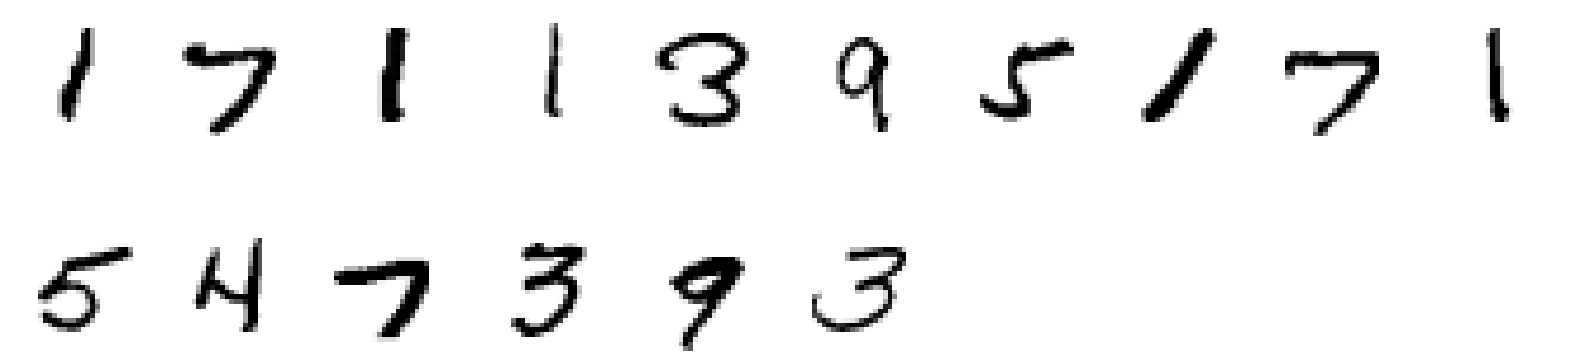

In [5]:
import numpy as np

 # 指定图片大小，图像大小为20宽、5高的绘图(单位为英寸inch)
plt.figure(figsize=(20, 5)) 
for i, imgs in enumerate(imgs[:20]):
    imgs = imgs.to(device)  # 将图片数据移动到指定的设备上
    imgs = imgs.cpu()  # 将图片数据移动到CPU上，以便进行numpy转换
    # np.squeeze() 函数用于去掉数组中维度为1的轴
    # 例如，将形状为 [1, 28, 28] 的数组转换为 [28, 28]
    # 这样可以方便地将图像数据传递给 matplotlib 进行绘图
    npimg = np.squeeze(imgs.numpy())
    # 将整个figure分成2行10列，绘制第i+1个子图。
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg, cmap=plt.cm.binary)
    plt.axis('off')
    
plt.show() 

In [6]:
import torch.nn.functional as F

num_classes = 10  # 图片的类别数

class Model(nn.Module):
    """定义一个卷积神经网络模型"""
    def __init__(self):
        super().__init__()
         # nn.Conv2d为卷积层，用于提取图片的特征，传入参数为输入channel，输出channel，卷积核大小
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 第一层卷积,输入通道为1，输出通道为32，卷积核大小为3*3
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        # nn.MaxPool2d为池化层，进行下采样，用更高层的抽象表示图像特征，传入参数为池化核大小
        self.pool1 = nn.MaxPool2d(2)                  # 最大池化层，池化核大小为2*2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # 第二层卷积,输入通道为32，输出通道为64，卷积核大小为3*3  
        self.pool2 = nn.MaxPool2d(2) # 最大池化层，池化核大小为2*2
                                      
        # 分类网络
        # nn.Linear为全连接层，，可以起到特征提取器的作用，最后一层的全连接层也可以认为是输出层，传入参数为输入特征数和输出特征数
        # 输入特征数为64，输出特征数为num_classes（10）
        # 这里的1600是根据输入图片大小和卷积层、池化层的参数计算得出的。
        # 经过两次卷积和池化后，图片的大小从28x28变为4x4，所以输入特征数为64*4*4=1600
        self.fc1 = nn.Linear(1600, 64)        
        # 第二个全连接层，输入特征数为64，输出特征数为num_classes（10）
        # 这里的num_classes是图片的类别数
        # 对于MNIST数据集，num_classes=10
        # 这意味着模型将输出一个长度为10的向量，每个元素表示对应类别的预测分数
        # 最终的分类结果将通过softmax函数转换为概率分布
        # softmax函数将输出向量中的每个元素转换为一个概率值，所有概率值的和为1
        # 例如，如果输出向量是[2.0, 1.0, 0.5, ..., 0.1]，
        # 则softmax函数将其转换为[0.7, 0.2, 0.1, ..., 0.01]，表示模型认为第一个类别的概率为70%，第二个类别的概率为20%，第三个类别的概率为10%，等等。       
        self.fc2 = nn.Linear(64, num_classes)

    # 定义前向传播函数
    # 前向传播函数定义了数据如何通过模型进行处理
    # 在这个函数中，我们将输入数据通过卷积层、池化层和全连接层进行处理，最终得到输出结果
    # 输入参数x是一个形状为 [batch_size, 1, 28, 28] 的张量，表示一批次的图片数据
    # 输出结果是一个形状为 [batch_size, num_classes] 的张量，表示每个样本的预测分数
    # 其中 batch_size 是每个批次的样本数量，num_classes 是图片的类别数
    def forward(self, x):
        # 将输入数据通过卷积层和池化层进行处理
        # F.relu() 是一个激活函数，用于引入非线性
        # 在卷积层之后使用ReLU激活函数可以增加模型的非线性，使得模型能够学习更复杂的特征
        # self.pool1 和 self.pool2 是最大池化层，用于下采样特征图，减少特征图的空间维度
        # 通过卷积层和池化层的组合，我们可以提取图片中的重要特征
        # 经过两次卷积和池化后，
        # 图片的大小从28x28变为4x4，所以输出特征图的形状为 [batch_size, 64, 4, 4]
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # 将特征图展平为一维向量
        # torch.flatten() 函数用于将多维张量展平为一维
        # start_dim=1 表示从第1维开始展平，保留第0维（batch_size）不变
        # 这样可以将形状为 [batch_size, 64, 4, 4] 的张量转换为形状为 [batch_size, 64*4*4] 的张量
        # 这里的64是输出通道数，4*4是特征图的空间维度
        # 展平后的张量可以直接输入到全连接层进行处理
        # 经过展平后，张量的形状变为 [batch_size, 1600]
        x = torch.flatten(x, start_dim=1)
        # 将展平后的特征向量通过全连接层进行处理
        # self.fc1 和 self.fc2 是全连接层，用于将特征向量映射到类别空间
        # F.relu() 是一个激活函数，用于引入非线性
        # 在全连接层之后使用ReLU激活函数可以增加模型的非线性，使得模型能够学习更复杂的特征
        # 最终的输出结果是一个形状为 [batch_size, num_classes] 的张量
        # 其中 num_classes 是图片的类别数
        # 对于MNIST数据集，num_classes=10
        # 这意味着模型将输出一个长度为10的向量，每个元素表示
        # 对应类别的预测分数
        # 最终的分类结果将通过softmax函数转换为概率分布
        # softmax函数将输出向量中的每个元素转换为一个概率值，
        # 所有概率值的和为1
        x = F.relu(self.fc1(x))
        # 将激活后的特征向量通过第二个全连接层进行处理
        x = self.fc2(x)
       
        return x

In [7]:
from torchinfo import summary
# 将模型转移到GPU中（我们模型运行均在GPU中进行）
model = Model().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            102,464
├─Linear: 1-6                            650
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0

In [8]:
# 定义损失函数和优化器
# nn.CrossEntropyLoss() 是一个用于多分类问题的损失函数
# 它结合了 softmax 函数和交叉熵损失函数，
# 可以直接用于多分类问题的训练
# 它的输入是模型的输出（未经过 softmax 函数处理的 logits），
# 输出是一个标量，表示模型的损失值
# 这个损失函数会自动计算 softmax 函数的输出，并与目标标签进行比较，
# 计算出模型的损失值
# 这个损失函数适用于多分类问题，特别是当类别数大于2 时
# 它可以处理多类别的分类问题，并且可以处理不平衡
# 类别的情况
# 例如，对于 MNIST 数据集，模型的输出是一个长度为 10 的
# 向量，每个元素表示对应类别的预测分数
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数

# torch.optim.SGD 是一个随机梯度下降优化器，用于更新模型的参数
# 它的输入是模型的参数和学习率
# 学习率是一个超参数，用于控制模型参数更新的步长
# 学习率过大会导致模型不收敛，学习率过小会导致模型收敛速度过慢
# 在这里，我们将学习率设置为 1e-2，即 0.01
# 这个学习率是一个常用的初始学习率，可以根据实际情况进行调整
# 优化器会根据损失函数的梯度信息来更新模型的参数
# 在每次迭代中，优化器会计算损失函数的梯度
# 然后根据学习率和梯度信息来更新模型的参数
# 例如，如果模型的参数是 w，损失函数的梯度是 dw，
# 那么优化器会将 w 更新为 w - learn_rate * dw
# 这样可以使模型的参数朝着最小化损失函数的方向更新
# 这里的 learn_rate 是一个超参数，用于控制模型参数更新的步长
# 在训练过程中，我们会不断地使用优化器来更新模型的参数，
# 以使模型的损失函数逐渐减小，从而提高模型的性能
learn_rate = 1e-2 # 学习率

# 创建优化器
# torch.optim.SGD 是一个随机梯度下降优化器，用于更新模型的参数        
opt= torch.optim.SGD(model.parameters(),lr=learn_rate)

In [9]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    """    训练函数
    :param dataloader: 数据加载器
    :param model: 待训练的模型
    :param loss_fn: 损失函数
    :param optimizer: 优化器
    """
    size = len(dataloader.dataset)  # 训练集的大小，一共60000张图片
    num_batches = len(dataloader)   # 批次数目，1875（60000/32）

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        # optimizer.zero_grad() 用于将优化器中的梯度清零
        # loss.backward() 用于计算损失函数的梯度
        # optimizer.step() 用于更新模型的参数
        # 这三个步骤是训练模型的核心部分
        # 在每次迭代中，我们需要清零梯度，计算梯度，
        # 然后更新模型的参数
        # 这样可以使模型的参数朝着最小化损失函数的方向更新参数
        # optimizer.zero_grad() 用于将优化器中的梯度清零
        # 这一步是为了避免梯度累积，因为在每次迭代中，
        # 优化器会将梯度累积到之前的梯度上
        # 如果不清零梯度，梯度会不断累积，导致模型参数更新不正确
        # loss.backward() 用于计算损失函数的梯度
        # 这一步是为了计算损失函数对模型参数的梯度
        # 通过计算梯度，我们可以知道模型参数应该如何更新
        # optimizer.step() 用于更新模型的参数
        # 这一步是根据损失函数的梯度信息来更新模型的参数
        # 优化器会根据学习率和梯度信息来更新模型的参数
        # 例如，如果模型的参数是 w，损失函数的梯度是 dw
        # 那么优化器会将 w 更新为 w - learn_rate * dw
        # 这样可以使模型的参数朝着最小化损失函数的方向更新参数
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        # pred.argmax(1) 返回每个样本预测的类别索引
        # y 是每个样本的真实类别标签
        # (pred.argmax(1) == y) 返回一个布尔张量，表示每个样本的预测是否正确
        # .type(torch.float) 将布尔张量转换为浮点数张量
        # .sum().item() 计算正确预测的样本数量
        # train_acc 记录正确预测的样本数量, 是正确预测的样本数量除以训练集的大小
        # train_loss 记录当前批次的损失值,是所有批次的损失值之和除以批次数
        # 这样可以得到训练集上的平均正确率和平均损失
        # 最终的 train_acc 和 train_loss 分别表示训练集上的正确率和平均损失,可以用来评估模型的性能
        # 如果训练集上的平均正确率较高，平均损失较低
        # 说明模型在训练集上表现良好，能够较好地拟合数据
        # 如果训练集上的平均正确率较低，平均损失较高
        # 说明模型在训练集上表现较差，可能存在过拟合或欠拟合的情况
        # 训练集上的平均正确率和平均损失可以用来调整模型的超参数
        # 例如，可以通过调整学习率、批次大小、网络结构等超参数来提高模型在训练集上的性能
        # 训练集上的平均正确率和平均损失可以用来监控模型的训练过程
        # 在每个epoch结束时，可以打印训练集上的平均正确率和平均损失，以便观察模型的训练情况
        # 如果训练集上的平均正确率逐渐提高，平均损失逐渐降低
        # 说明模型在训练过程中逐渐学习到了数据的特征
        # 如果训练集上的平均正确率没有明显变化，平均损失没有明显降低
        # 说明模型可能已经收敛，或者存在过拟合或欠拟合的情况
        # 在这种情况下，可以尝试调整模型的超参数，或者使用更复杂的模型来提高模型的性能
        # 训练集上的平均正确率和平均损失可以用来评估模型
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [ ]:
def test (dataloader, model, loss_fn):
    """测试函数
    :param dataloader: 数据加载器
    :param model: 待测试的模型
    :param loss_fn: 损失函数
    """
    size = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

: 

In [ ]:
# 训练模型
# 训练模型的过程包括多个epoch，每个epoch包含多个批次（batch）
epochs     = 5
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    # 每个epoch开始时，先将模型设置为训练模式
    # 这会启用模型中的一些特定于训练的功能，例如 dropout 和 batch normalization
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
    
    
    model.eval() # 将模型设置为评估模式
    # 在评估模式下，模型不会进行梯度更新，也不会启用 dropout
    # 这使得模型在测试集上的表现更加稳定
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn) 
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')